# 2D Steady-State Heat Conduction Equation with Source 

Consider the steady-state heat conduction equation with a heat source, q. The source/forcing term  drives the solution to its steady state.

$$
\begin{equation}
\alpha\nabla^2 T = q
\end{equation}
$$


$$
\implies \frac{\partial ^2 T}{\partial x^2} + \frac{\partial ^2 T}{\partial y^2} = \frac{1}{\alpha}q
$$

In discretized form, this looks almost the same as the Laplace Equation, except for the source term on the right-hand side:

$$
\frac{T_{i,j+1}^k - 2T_{i,j}^k + T_{i,j-1}^k}{\Delta x^2} + \frac{T_{i+1,j}^k - 2T_{i,j}^k + T_{i-1,j}^k}{\Delta y^2} =  \frac{1}{\alpha}q
$$

**Note**: that $k$ here is not a time index, but an index indicating the current iteration number, when perfoming relaxation schemes.

Then we re-arrange and solve for the new **(i,j) point**, i.e. $T_{i,j}^{k+1}$: 

Let us suppose that the analytical solution to the equation is:

$$
T(x,y) = \frac{\sin(2\pi x)\sin(2\pi y)}{\alpha} \\
\implies  \nabla^2T(x,y) = \frac{-8\pi^2\sin(2\pi x)\sin(2\pi y)}{\alpha}
$$

You will use the following inputs to your code.

* $L_x, L_y = 1,1 \;$
* $\alpha = 10 \;$
* $nx, ny = 62,62$ (including the 2 ghost cells)

Initial condition:
$$\begin{equation} T(x,y,t=0) = 0 \; \end{equation} $$

Boundary conditions for T:
$  \; $ 

$$\begin{equation} T(x=0,y,t) = 0 \; \end{equation} \;\;\;\;\;\; (Dirichlet \; BC) $$ 

$$\begin{equation} T(x=L,y,t) = 0 \; \end{equation} \;\;\;\;\;\; (Dirichlet \; BC) $$ 

$$\begin{equation} T(x,y=0,t) = 0 \; \end{equation} \;\;\;\;\;\; (Dirichlet \; BC) $$ 

$$\begin{equation} T(x,y=L,t) = 0 \; \end{equation} \;\;\;\;\;\; (Dirichlet \; BC) $$

and then try 

$$\begin{equation} \frac{\partial T}{\partial x}(x=0,y,t) = 0 \; \end{equation} \;\;\; (Neumann \; BC) $$ 

$$\begin{equation} \frac{\partial T}{\partial x}(x=L,y,t) = 0 \; \end{equation} \;\;\; (Neumann \; BC) $$ 

$$\begin{equation} \frac{\partial T}{\partial y}(x,y=0,t) = 0 \; \end{equation} \;\;\; (Neumann \; BC) $$ 

$$\begin{equation} \frac{\partial T}{\partial y}(x,y=L,t) = 0 \; \end{equation} \;\;\; (Neumann \; BC) $$


<img src="grid_figure.png" width="700">

To follow the above figure as well as the indexing in the above discretized equations, we choose to initialise our variable as **[ny,nx]** in order to keep physical orientation and define the direction of the axes via the BC.

## Jacobi method
$$
T_{i,j}^{k+1}=\frac{(T_{i+1,j}^{k}+T_{i-1,j}^{k})\Delta x^2+(T_{i,j+1}^{k}+T_{i,j-1}^{k})\Delta y^2-\frac{1}{\alpha}q_{i,j}^{k}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}
$$

## Gauss-Seidel method
$$
T_{i,j}^{k+1}=\frac{(T_{i+1,j}^{k}+T_{i-1,j}^{k+1})\Delta x^2+(T_{i,j+1}^{k}+T_{i,j-1}^{k+1})\Delta y^2-\frac{1}{\alpha}q_{i,j}^{k}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}
$$

## Successive Over-Relaxation method
$$
T_{i,j}^{k+1}= (1-\omega) + \omega\frac{(T_{i+1,j}^{k}+T_{i-1,j}^{k+1})\Delta x^2+(T_{i,j+1}^{k}+T_{i,j-1}^{k+1})\Delta y^2-\frac{1}{\alpha}q_{i,j}^{k}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}
$$

In [1]:
#---------- Import libraries ----------

import numpy
import time
import matplotlib.pyplot as plt
from helper import plot_3d

In [10]:
#---------- Define Functions ----------

def get_ic(nx,ny):
    
    """
    
    It sets the IC for the var
    
    nx : integer
         number of points in x-direction
              
    ny : integer
         number of points in y-direction
    
    """
    
    var = numpy.zeros((ny,nx))
    
    return var


def update_bc(var):
    
    """
    
    It updates the BCs for the var
    
    var : float
          solution of the PDE at the time-step i
    
    """    
    # BC West & East
    var[:,  0] = 0
    var[:, -1] = 0
    
    # BC South & North    
    var[ 0, :] = 0
    var[-1, :] = 0
    
    return var


def get_source(var,X,Y):
    
    """
    
    It computes the source term of the equation
    
    var : float
          solution of the PDE at the time-step i
          
    X   : array
          2D x-grid
         
    Y   : array
          2D y-grid
    
    """

    source = - 8 * (numpy.pi ** 2) * numpy.sin(2 * numpy.pi * X) * numpy.sin(2 * numpy.pi * Y)
    
    return source


def jacobi(var,X,Y,dx,dy,alpha,maxiter=3000,tolerance=1e-9):
    
    """
    
    It solves thes Poisson equation using the Jacobi method
    
    var       : float
                solution of the PDE at a given the time-step i
                
    X         : array
                2D x-grid
         
    Y         : array
                2D y-grid
    
    dx        : float
                space-step of numerical method in x-direction
         
    dy        : float
                space-step of numerical method in y-direction
    
    alpha     : float
                diffusivity constant
          
    maxiter   : integer
                maximum number of corrcetion cycles/iterations repeated
              
    tolerance : float
                maximum accepted error in order to exit loop
    
    """

    # Get RHS
    q   = get_source(var,X,Y)
    rhs = q / alpha

    # Initialise variables for the loop
    iters       = 0
    difference  = tolerance + 1.0
    error_max   = numpy.zeros(maxiter)
    number_iter = numpy.zeros(maxiter)

    start = time.time()
    
    # Solve the linear system
    while (iters < maxiter and difference > tolerance):
        
        # Previous solution
        var_old = numpy.copy(var)
        
        # Calcualte new solution using VECTORIZED OPERATIONS
        var[1:-1,1:-1] = ((var[1:-1, 2:] + var[1:-1, :-2])*dx**2 + 
                          (var[2:, 1:-1] + var[:-2, 1:-1])*dy**2 - 
                          (rhs[1:-1, 1:-1] * (dx * dy)**2 ) /
                          (2*(dx**2 + dy**2))
                         )

        # Update BC
        var = update_bc(var)

        # Compute difference as a normalised L2-norm
        difference = (numpy.sqrt(numpy.sum((var - var_old) ** 2) / (nx * ny)))

        # Update iteration variables
        iters                 += 1
        number_iter[iters - 1] = iters

    end = time.time()
    duration = end-start

    # Print statistics
    print('Jacobi method:')
    if iters == maxiter:
        print('Warning: maximum number of iterations reached!')
    print('~ Number of iterations: {}'.format(iters))
    print('~ Final difference: {}'.format(difference))
    print('~ Time: {0:.4f}'.format(duration),'sec')

    return var, duration, number_iter


def gauss_seidel(var,X,Y,dx,dy,alpha,maxiter=3000,tolerance=1e-9):
    
    """
    
    It solves thes Poisson equation using the Gauss-Seidel method
    
    var       : float
                solution of the PDE at a given the time-step i
                
    X         : array
                2D x-grid
         
    Y         : array
                2D y-grid
    
    dx        : float
                space-step of numerical method in x-direction
         
    dy        : float
                space-step of numerical method in y-direction
    
    alpha     : float
                diffusivity constant
          
    maxiter   : integer
                maximum number of corrcetion cycles/iterations repeated
              
    tolerance : float
                maximum accepted error in order to exit loop
    
    """

    # Get RHS
    q   = get_source(var,X,Y)
    rhs = q / alpha

    # Initialise variables for the loop
    iters       = 0
    difference  = tolerance + 1.0
    error_max   = numpy.zeros(maxiter)
    number_iter = numpy.zeros(maxiter)

    start = time.time()
    
    # Solve the linear system
    while (iters < maxiter and difference > tolerance):
        
        # Previous solution
        var_old = numpy.copy(var)
        
        for i in range (1,ny-1):     # Note : Only wok in the interior points
            for j in range (1,nx-1):
                # Calcualte new solution
                var[i,j] = ((var[i, j + 1] + var[i, j - 1])*dy**2 + 
                            (var[i + 1, j] + var[i - 1, j])*dx**2 - 
                            (rhs[i, j] * (dx * dy)**2 ) /
                            (2*(dx**2 + dy**2))
                           )

        # Update BC
        var = update_bc(var)

        # Compute difference as a normalised L2-norm
        difference = (numpy.sqrt(numpy.sum((var - var_old) ** 2) / (nx * ny)))

        # Update iteration variables
        iters                 += 1
        number_iter[iters - 1] = iters

    end = time.time()
    duration = end-start

    # Print statistics
    print('Gauss-Seidel method:')
    if iters == maxiter:
        print('Warning: maximum number of iterations reached!')
    print('~ Number of iterations: {}'.format(iters))
    print('~ Final difference: {}'.format(difference))
    print('~ Time: {0:.4f}'.format(duration),'sec')

    return var, duration, number_iter


def sor(var,X,Y,dx,dy,alpha,maxiter=3000,tolerance=1e-9):
    
    """
    
    It solves thes Poisson equation using the Successive Over-Relaxation method
    
    var       : float
                solution of the PDE at a given the time-step i
                
    X         : array
                2D x-grid
         
    Y         : array
                2D y-grid
    
    dx        : float
                space-step of numerical method in x-direction
         
    dy        : float
                space-step of numerical method in y-direction
    
    alpha     : float
                diffusivity constant
          
    maxiter   : integer
                maximum number of corrcetion cycles/iterations repeated
              
    tolerance : float
                maximum accepted error in order to exit loop
    
    """

    # Get RHS
    q   = get_source(var,X,Y)
    rhs = q / alpha

    # Initialise variables for the loop
    iters       = 0
    difference  = tolerance + 1.0
    error_max   = numpy.zeros(maxiter)
    number_iter = numpy.zeros(maxiter)
    omega       = 1.5

    start = time.time()
    
    # Solve the linear system
    while (iters < maxiter and difference > tolerance):
        
        # Previous solution
        var_old = numpy.copy(var)
        
        for i in range (1,ny-1):     # Note : Only wok in the interior points
            for j in range (1,nx-1):
                # Calcualte new solution
                var[i,j] = ((1-omega) * var[i,j] +
                            omega *
                            ((var[i, j + 1] + var[i, j - 1])*dy**2 + 
                             (var[i + 1, j] + var[i - 1, j])*dx**2 - 
                             (rhs[i, j] * (dx * dy)**2 ) /
                             (2*(dx**2 + dy**2)))
                           )

        # Update BC
        var = update_bc(var)

        # Compute difference as a normalised L2-norm
        difference = (numpy.sqrt(numpy.sum((var - var_old) ** 2) / (nx * ny)))
#         difference = 1

        # Update iteration variables
        iters                 += 1
        number_iter[iters - 1] = iters

    end = time.time()
    duration = end-start

    # Print statistics
    print('Successive Over-Relaxation method:')
    if iters == maxiter:
        print('Warning: maximum number of iterations reached!')
    print('~ Number of iterations: {}'.format(iters))
    print('~ Final difference: {}'.format(difference))
    print('~ Time: {0:.4f}'.format(duration),'sec')

    return var, duration, number_iter

In [11]:
#---------- Define inputs ----------

alpha          = 10
lx_max, ly_max = 1, 1
nx, ny         = 62, 62

In [12]:
#---------- Solve the equation ----------

# Initialise space arrays
x  = numpy.linspace(0,lx_max,nx)
dx = x[1] - x[0]
y  = numpy.linspace(0,ly_max,ny)
dy = y[1] - y[0]
X,Y = numpy.meshgrid(x,y)

# Apply IC
var = get_ic(nx,ny)

# Update BC
var = update_bc(var)

# Solve with Jacobi    
var, duration, number_iter = sor(var,X,Y,dx,dy,alpha,maxiter=3000,tolerance=1e-9)

Successive Over-Relaxation method:
~ Number of iterations: 20
~ Final difference: 7.35906428293211e-10
~ Time: 0.3264 sec


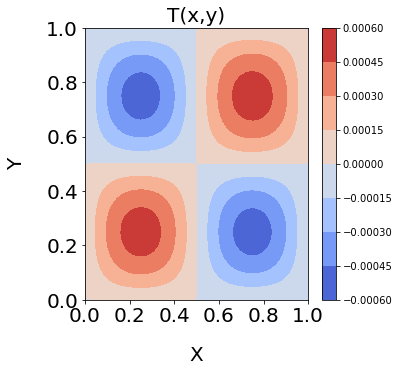

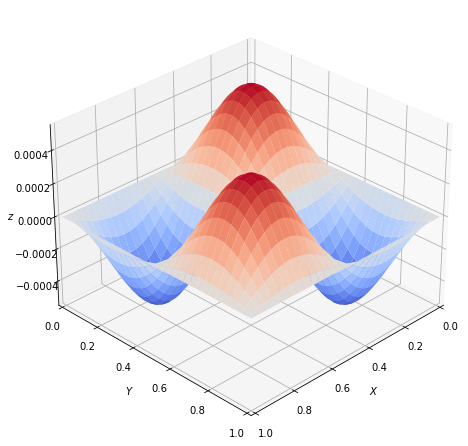

In [13]:
# Plot field in 2D
plt.figure(figsize=(5,5))
size = 20
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.xlabel('X', labelpad=20, fontsize=size)
plt.ylabel('Y', labelpad=20, fontsize=size)
plt.contourf(X,Y,var,cmap='coolwarm')
plt.colorbar()
plt.title('T(x,y)',fontsize=size)
plt.show()

# Plot field in 3D
plot_3d(x, y, var)